## Read Me

In [ ]:
# # uv pip install pyodbc pandas python-dotenv
# sudo apt-get update
# sudo apt-get install unixodbc unixodbc-dev


In [ ]:
# ## Installing SQL SERVER Driver
# curl https://packages.microsoft.com/keys/microsoft.asc | sudo apt-key add -
# curl https://packages.microsoft.com/config/ubuntu/22.04/prod.list | sudo tee /etc/apt/sources.list.d/mssql-release.list


# sudo apt-get update
# sudo ACCEPT_EULA=Y apt-get install -y msodbcsql17

# sudo apt-get install -y unixodbc unixodbc-dev


# --- sudo nano /etc/odbcinst.ini
# [ODBC Driver 17 for SQL Server]
# Description=Microsoft ODBC Driver 17 for SQL Server
# Driver=/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.8.so.1.1
# UsageCount=1


# sudo nano /etc/odbc.ini
# [SQLSERVER]
# Driver=ODBC Driver 17 for SQL Server
# Server=your_server_name
# Database=your_database_name
# Port=1433



# STARTER

In [1]:
import os
import pyodbc
import pandas as pd
from dotenv import load_dotenv

import folium

# Load environment variables from .env file
load_dotenv()

True

### 01. Get Data

In [2]:
def get_connection():
    # Retrieve connection parameters from environment variables
    server = os.getenv('DB_HOST_OMNIBIZ_REPLICA')
    database = os.getenv('DB_DATABASE_OMNIBIZ_REPLICA')
    username = os.getenv('DB_USER_OMNIBIZ_REPLICA')
    password = os.getenv('DB_PASSWORD_OMNIBIZ_REPLICA')
    driver = os.getenv('DB_DRIVER')

    # Establish the connection
    connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
    conn = pyodbc.connect(connection_string)
    return conn

In [3]:
def execute_stored_procedure():
    # Get a database connection
    conn = get_connection()
    cursor = conn.cursor()

    # Execute the stored procedure
    cursor.execute("{CALL sp_GetCustomerSKUSalesRecommendationALGO()}")

    # Fetch the first result set into a DataFrame
    rows = cursor.fetchall()
    df1 = pd.DataFrame.from_records(rows, columns=[column[0] for column in cursor.description])

    # Fetch the second result set if it exists
    if cursor.nextset():
        rows = cursor.fetchall()
        df2 = pd.DataFrame.from_records(rows, columns=[column[0] for column in cursor.description])
    else:
        df2 = pd.DataFrame()  # Return an empty DataFrame if there's no second result set
    
    # Fetch the second result set if it exists
    if cursor.nextset():
        rows = cursor.fetchall()
        df3 = pd.DataFrame.from_records(rows, columns=[column[0] for column in cursor.description])
    else:
        dfdf32 = pd.DataFrame()  # Return an empty DataFrame if there's no second result set

    # Close the cursor and connection
    cursor.close()
    conn.close()

    return df1, df2, df3

In [4]:
# Execute the function and get the DataFrames
df1, df2, df3 = execute_stored_procedure()

# Print the DataFrames
print("DataFrame 1:")
print(df1.shape)
print("\nDataFrame 2:")
print(df2.shape) 
print("\nDataFrame 3:")
print(df3.shape)


# Avg. Run Time: 5mins

DataFrame 1:
(154108, 13)

DataFrame 2:
(10849, 22)

DataFrame 3:
(68, 4)


In [5]:
df1.to_feather('./input/customer_sku_recommendation.feather')
df2.to_feather('./input/customer_dim_with_affinity_score.feather')
df3.to_feather('./input/stockpoint_dim.feather')

# 02. SETUP AND PREPROCESSING

In [44]:
import pandas as pd 
import matplotlib.pyplot as plt
import folium 
from datetime import datetime 

In [9]:
## Load Data
df_customer_sku_recommendation_raw = pd.read_feather('./input/customer_sku_recommendation.feather').rename(columns={'FCID':'Stock_Point_ID','CustomerId':'CustomerID'})
df_customer_dim_with_affinity_score_raw = pd.read_feather('./input/customer_dim_with_affinity_score.feather').rename(columns={'FCID':'Stock_Point_ID'})
df_stockpoint_dim_raw = pd.read_feather('./input/stockpoint_dim.feather')

In [16]:
df_customer_sku_recommendation_raw.LastDeliveredDate.describe()
# ['Stock_Point_ID', 'CustomerID', 'SKUID', 'ProductName', 'Output',
#        'LastDeliveredDate', 'InventoryCheck', 'ProductTag', 'Medium',
#        'EstimatedQuantity', 'CustomerSKUscore', 'CustomerSKUscoreStandardize',
    #    'CustomerSKUscoreRank']

count                           154751
mean     1957-08-15 18:44:12.979302208
min                1900-01-01 00:00:00
25%                1900-01-01 00:00:00
50%                1900-01-01 00:00:00
75%                2025-05-01 00:00:00
max                2025-06-08 00:00:00
Name: LastDeliveredDate, dtype: object

### 2.1 PREPROCESSING

In [ ]:
def preprocessing(df_customer_sku_recommendation_raw, df_customer_dim_with_affinity_score_raw, df_stockpoint_dim_raw) :
    df_customer_sku_recommendation_raw['Stock_Point_ID'] = df_customer_sku_recommendation_raw['Stock_Point_ID'].astype(int)
    df_customer_dim_with_affinity_score_raw['Stock_Point_ID'] = df_customer_dim_with_affinity_score_raw['Stock_Point_ID'].astype(int)
    df_stockpoint_dim_raw['Stock_Point_ID'] = df_stockpoint_dim_raw['Stock_Point_ID'].astype(int)

    col1 = ['Latitude', 'Longitude','TotalSKUs', 'AvgSKUScore', 'TotalEstimatedVolume', 'RFcount', 'HighValueSKUs', 
            'HighValueAvgScore', 'HighValueTotalScore', 'HighValueEstimatedVolume', 'ExpressSKUs', 
            'CoreSKUs', 'CustomerAffinityScore_Raw', 'CustomerAffinityScore_Standardized', 'CustomerAffinityRank']

    for col in col1: 
        df_customer_dim_with_affinity_score_raw[col] = pd.to_numeric(df_customer_dim_with_affinity_score_raw[col], errors='coerce').fillna(0)

    col2 = ['EstimatedQuantity', 'CustomerSKUscore', 'CustomerSKUscoreStandardize', 'CustomerSKUscoreRank']
    for col in col2: 
        df_customer_sku_recommendation_raw[col] = pd.to_numeric(df_customer_sku_recommendation_raw[col], errors='coerce')

    df_customer_sku_recommendation_raw['LastDeliveredDate'] = pd.to_datetime(df_customer_sku_recommendation_raw['LastDeliveredDate'])
    # Get today's date
    today = pd.Timestamp.today()

    df_customer_sku_recommendation_raw['Recency'] = df_customer_sku_recommendation_raw['LastDeliveredDate'].apply(lambda x: (datetime.now() - x).days)
    df_customer_sku_recommendation_raw['Recency'] = df_customer_sku_recommendation_raw['Recency'].fillna(max(df_customer_sku_recommendation_raw['Recency']))
    df_stockpoint_dim_raw.rename(columns={'lattitude':'Latitude', 'longitude':'Longitude'}, inplace=True) 
    col3 = ['Latitude', 'Longitude']
    for col in col3: 
        df_stockpoint_dim_raw[col] = pd.to_numeric(df_stockpoint_dim_raw[col], errors='coerce')   

    # Replace invalid latitude values with NaN
    df_customer_dim_with_affinity_score_raw.loc[
        (df_customer_dim_with_affinity_score_raw['Latitude'] < -90) |
        (df_customer_dim_with_affinity_score_raw['Latitude'] > 90),
        'Latitude'
    ] = 0.0

    df_customer_dim_with_affinity_score_raw.loc[
        (df_customer_dim_with_affinity_score_raw['Longitude'] < -180) |
        (df_customer_dim_with_affinity_score_raw['Longitude'] > 180),
        'Longitude'
    ] = 0.0   


    return df_customer_sku_recommendation_raw, df_customer_dim_with_affinity_score_raw, df_stockpoint_dim_raw

In [61]:
sum(df_customer_sku_recommendation_raw.Recency <= 14)

10725

In [134]:
print('Number of customers with longitude outsize +- 180: ',
      df_customer_dim_with_affinity_score_raw[
        (df_customer_dim_with_affinity_score_raw['Longitude'] < -180) |
        (df_customer_dim_with_affinity_score_raw['Longitude'] > 180) 
    ].shape[0])

print('Number of customers with Latitude outsize +- 90: ',
      df_customer_dim_with_affinity_score_raw[
        (df_customer_dim_with_affinity_score_raw['Latitude'] < -90) |
        (df_customer_dim_with_affinity_score_raw['Latitude'] > 90) 
    ].shape[0])

print('Number of customers with longitude outsize +- 180: ',
      df_stockpoint_dim_raw[
        (df_stockpoint_dim_raw['Longitude'] < -180) |
        (df_stockpoint_dim_raw['Longitude'] > 180) 
    ].shape[0])

print('Number of customers with Latitude outsize +- 90: ',
      df_stockpoint_dim_raw[
        (df_stockpoint_dim_raw['Latitude'] < -90) |
        (df_stockpoint_dim_raw['Latitude'] > 90) 
    ].shape[0])

Number of customers with longitude outsize +- 180:  0
Number of customers with Latitude outsize +- 90:  1
Number of customers with longitude outsize +- 180:  0
Number of customers with Latitude outsize +- 90:  0


count    156061.000000
mean          3.055126
std          15.166226
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        3777.000000
Name: EstimatedQuantity, dtype: float64


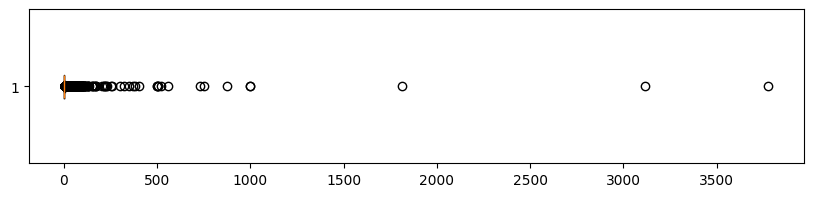

In [135]:
print(df_customer_sku_recommendation_raw['EstimatedQuantity'].describe()) 

fig = plt.figure(figsize =(10, 2))
plt.boxplot(df_customer_sku_recommendation_raw['EstimatedQuantity'], orientation='horizontal')
plt.show()

array([[<Axes: title={'center': 'nSKU'}>]], dtype=object)

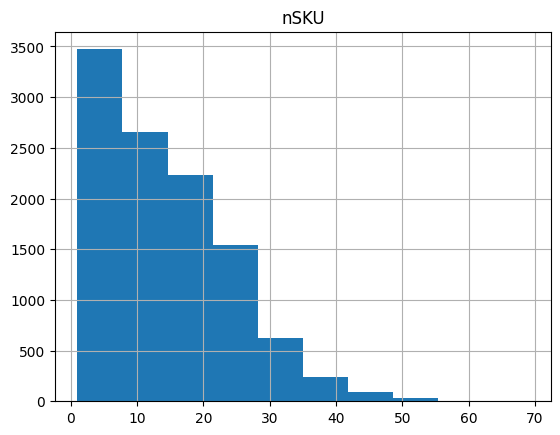

In [136]:
# Number of SKU Recommended per Customer
(
    df_customer_sku_recommendation_raw
    .groupby('CustomerID')['SKUID']
    .count()
    .reset_index(name='nSKU')
    # .groupby('nSKU')['CustomerID']
    # .count()
    # .reset_index(name='nCustomer')
).hist('nSKU')

### 2.2. Filter and Data Cleaning

In [137]:
df_customer_sku_recommendation = df_customer_sku_recommendation_raw.copy()
df_customer_dim_with_affinity_score = df_customer_dim_with_affinity_score_raw.copy()
df_stockpoint_dim = df_stockpoint_dim_raw.copy()


# Replace invalid latitude values with NaN
df_customer_dim_with_affinity_score.loc[
    (df_customer_dim_with_affinity_score['Latitude'] < -90) |
    (df_customer_dim_with_affinity_score['Latitude'] > 90),
    'Latitude'
] = 0.0

df_customer_dim_with_affinity_score.loc[
    (df_customer_dim_with_affinity_score['Longitude'] < -180) |
    (df_customer_dim_with_affinity_score['Longitude'] > 180),
    'Longitude'
] = 0.0   


# Filter Recommendation
df_customer_sku_recommendation = df_customer_sku_recommendation[df_customer_sku_recommendation['ProductTag'] != 'Standard-Inactive']
df_customer_sku_recommendation = df_customer_sku_recommendation[df_customer_sku_recommendation['Medium'] != 'Never Purchased']

# Select top 10 SKU by SKURank per customer
df_customer_sku_recommendation = (
    df_customer_sku_recommendation
    .sort_values(['CustomerID','CustomerSKUscoreRank'])
    .groupby('CustomerID', group_keys=False)
    .head(5)
    .reset_index(drop=True) 
)

# df_customer_sku_recommendation = df_customer_sku_recommendation[df_customer_sku_recommendation['CustomerSKUscoreRank'] <= 10]

# Clipping Max Estimated Quantity to 10 qty
df_customer_sku_recommendation['EstimatedQuantity_bck'] = df_customer_sku_recommendation['EstimatedQuantity']
df_customer_sku_recommendation['EstimatedQuantity'] = df_customer_sku_recommendation['EstimatedQuantity'].apply(lambda x: 5 if int((x*0.90)) > 5 else int((x*0.90)) )

Total Quantity Before clipping: : 476786 
After Clipping:  142568
   EstimatedQuantity  count
5                  0   4080
4                  3   6554
3                  2   8409
2                  1   8494
1                  4   9911
0                  5  11590
count    49038.000000
mean         2.907296
std          1.658944
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: EstimatedQuantity, dtype: float64


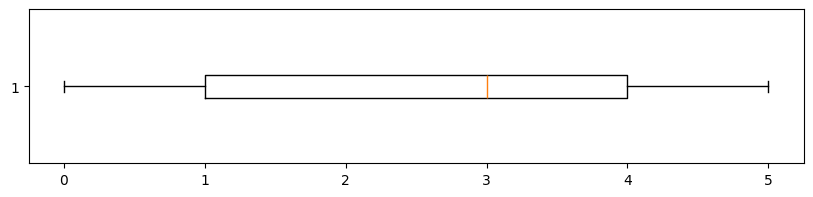

In [138]:
print('Total Quantity Before clipping: :', df_customer_sku_recommendation_raw['EstimatedQuantity'].sum(), '\nAfter Clipping: ', df_customer_sku_recommendation['EstimatedQuantity'].sum())
print(df_customer_sku_recommendation['EstimatedQuantity'].value_counts().reset_index().sort_values('count')) 
print(df_customer_sku_recommendation['EstimatedQuantity'].describe()) 

fig = plt.figure(figsize =(10, 2))
plt.boxplot(df_customer_sku_recommendation['EstimatedQuantity'], orientation='horizontal')
plt.show()

array([[<Axes: title={'center': 'nSKU'}>]], dtype=object)

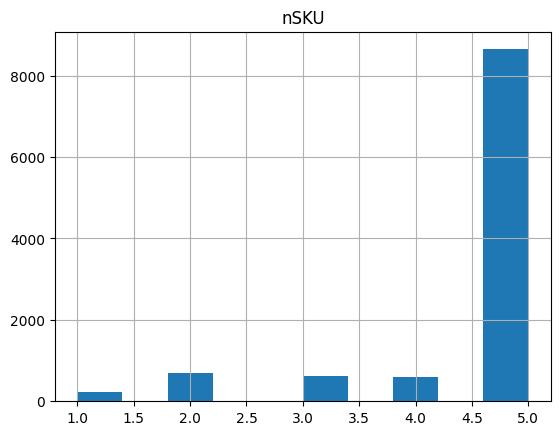

In [139]:
# Number of SKU Recommended per Customer
(
    df_customer_sku_recommendation 
    .groupby('CustomerID')['SKUID']
    .count()
    .reset_index(name='nSKU') 
).hist('nSKU')

In [140]:
print(df_customer_dim_with_affinity_score.columns.tolist())
print(df_customer_sku_recommendation.columns.tolist())
print(df_stockpoint_dim.columns.tolist())

['Stock_Point_ID', 'CustomerID', 'Name', 'StateName', 'Region', 'Latitude', 'Longitude', 'LGA', 'LCDA', 'TotalSKUs', 'AvgSKUScore', 'TotalEstimatedVolume', 'RFcount', 'HighValueSKUs', 'HighValueAvgScore', 'HighValueTotalScore', 'HighValueEstimatedVolume', 'ExpressSKUs', 'CoreSKUs', 'CustomerAffinityScore_Raw', 'CustomerAffinityScore_Standardized', 'CustomerAffinityRank']
['Stock_Point_ID', 'CustomerID', 'SKUID', 'ProductName', 'Output', 'LastDeliveredDate', 'InventoryCheck', 'ProductTag', 'Medium', 'EstimatedQuantity', 'CustomerSKUscore', 'CustomerSKUscoreStandardize', 'CustomerSKUscoreRank', 'EstimatedQuantity_bck']
['Stock_Point_ID', 'Stock_point_Name', 'Latitude', 'Longitude']


In [141]:
df_customer_sku_recommendation['Medium'].unique()

array(['Once in 8 Weeks', 'Probability', 'RF', 'Past Purchased'],
      dtype=object)

In [142]:
print(df_customer_sku_recommendation_raw.EstimatedQuantity.sum()) #26648
print(df_customer_sku_recommendation.EstimatedQuantity.sum()) #26648
print(df_customer_sku_recommendation.EstimatedQuantity_bck.sum()) #37847

476786
142568
251245


count   10,773.00
mean        13.23
std          6.14
min          0.00
25%          8.00
50%         13.00
75%         18.00
max         25.00
Name: TotalQty, dtype: float64


array([[<Axes: title={'center': 'TotalQty'}>]], dtype=object)

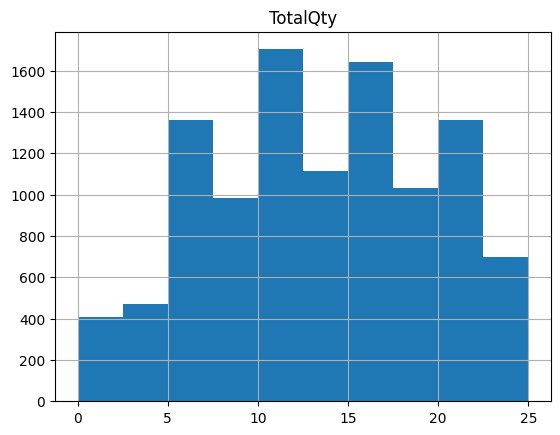

In [143]:
dist_totalQty_perCust = df_customer_sku_recommendation.groupby('CustomerID')['EstimatedQuantity'].sum().reset_index(name='TotalQty')

with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(dist_totalQty_perCust['TotalQty'].describe())

dist_totalQty_perCust.hist('TotalQty')

In [144]:
df_customer_sku_recommendation.shape

(49038, 14)

### Causeway

In [145]:
causeway = df_customer_sku_recommendation.query('Stock_Point_ID == 1647113')
causeway.shape

(5119, 14)

In [151]:
causeway_stockpoint = df_stockpoint_dim.query('Stock_Point_ID == 1647113').reset_index(drop=True)
causeway_stockpoint

Stock_Point_ID                Stock_point_Name  Latitude  Longitude
0         1647113  OmniHub Apapa Lagos - CAUSEWAY  6.473953   3.356525

In [153]:
causeway.to_excel('./output/causeway.xlsx', index=False)
causeway_stockpoint.to_feather('./output/causeway_stockpoint.feather')

In [ ]:
dist_totalQty_perCust_causeway = causeway.groupby('CustomerID')['EstimatedQuantity'].sum().reset_index(name='TotalQty')

with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(dist_totalQty_perCust_causeway['TotalQty'].describe())

dist_totalQty_perCust_causeway.hist('TotalQty')

In [ ]:
# print(df_customer_dim_with_affinity_score.dtypes)
# print(df_customer_sku_recommendation.dtypes)
# print(df_stockpoint_dim.dtypes)

In [ ]:
df_customer_dim_with_affinity_score.Stock_Point_ID.unique()

In [ ]:
# Customer Data:

# Customer locations (coordinates, or postal codes): df_customer_dim_with_affinity_score
# Customer IDs and names: df_customer_dim_with_affinity_score
# Priority levels or sales potential scores from your recommendation system
# Expected visit duration or service time per customer
# Customer availability windows (preferred visit times, business hours)
# Any special requirements or constraints (delivery volume, equipment needs)

In [ ]:
# 1. df_customer_sku_recommendation: 
# ['FCID', 'CustomerId', 'SKUID', 'ProductName', 'Output', 'LastDeliveredDate', 'InventoryCheck', 'ProductTag', 'Medium', 'EstimatedQuantity', 'CustomerSKUscore', 'CustomerSKUscoreStandardize', 'CustomerSKUscoreRank']
# 2. df_customer_dim_with_affinity_score:  
# ['FCID', 'CustomerID', 'Name', 'StateName', 'Region', 'Latitude', 'Longitude', 'LGA', 'LCDA', 'TotalSKUs', 'AvgSKUScore', 'TotalEstimatedVolume', 'RFcount', 'HighValueSKUs', 'HighValueAvgScore', 'HighValueTotalScore', 'HighValueEstimatedVolume', 'ExpressSKUs', 'CoreSKUs', 'CustomerAffinityScore_Raw', 'CustomerAffinityScore_Standardized', 'CustomerAffinityRank']
# 3. df_stockpoint_dim 
# ['Stock_Point_ID', 'Stock_point_Name', 'lattitude', 'longitude']

# IMPLEMENTATION

### IMPLEMENTATION 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

class RouteOptimizer:
    def __init__(self, max_customers_per_route=20, max_volume_per_route=200):
        self.max_customers_per_route = max_customers_per_route
        self.max_volume_per_route = max_volume_per_route
        self.distance_matrix = None
        
    def load_data(self, df_customer_sku_recommendation, df_customer_dim_with_affinity_score, df_stockpoint_dim):
        """Load and validate input datasets"""
        self.df_sku_rec = df_customer_sku_recommendation.copy()
        self.df_customer_dim = df_customer_dim_with_affinity_score.copy()
        self.df_stockpoint = df_stockpoint_dim.copy()
        
        print(f"Loaded {len(self.df_sku_rec)} SKU recommendations")
        print(f"Loaded {len(self.df_customer_dim)} customer records")
        print(f"Loaded {len(self.df_stockpoint)} stock points")
        
    def filter_customers_for_stockpoint(self, stock_point_id):
        """Filter and prepare customer data for specific stock point"""
        
        # Filter customers for the stock point
        customers = self.df_customer_dim[
            self.df_customer_dim['Stock_Point_ID'] == stock_point_id
        ].copy()
        
        # Filter SKU recommendations for the stock point
        sku_recs = self.df_sku_rec[
            self.df_sku_rec['Stock_Point_ID'] == stock_point_id
        ].copy()
        
        # Get customers with top 10 SKU recommendations
        top_sku_customers = sku_recs[
            sku_recs['CustomerSKUscoreRank'] <= 10
        ]['CustomerID'].unique()
        
        # Filter customers to only include those with top SKU recommendations
        customers = customers[customers['CustomerID'].isin(top_sku_customers)]
        
        # Aggregate SKU data per customer
        customer_sku_agg = sku_recs.groupby('CustomerID').agg({
            'EstimatedQuantity': 'sum',
            'CustomerSKUscore': 'mean',
            'CustomerSKUscoreRank': 'min',  # Best rank
            'ProductTag': lambda x: ','.join(x.unique())
        }).reset_index()
        
        # Merge customer data with aggregated SKU data
        customers_final = customers.merge(
            customer_sku_agg, 
            left_on='CustomerID', 
            right_on='CustomerID', 
            how='inner'
        )
        
        # Calculate priority scores
        customers_final = self._calculate_priority_scores(customers_final)
        
        print(f"Stock Point {stock_point_id}: {len(customers_final)} eligible customers")
        return customers_final
    
    def _calculate_priority_scores(self, customers_df):
        """Calculate different priority scoring options"""
        
        # Normalize scores to 0-1 range
        customers_df['affinity_score_norm'] = (
            customers_df['CustomerAffinityScore_Standardized'] - 
            customers_df['CustomerAffinityScore_Standardized'].min()
        ) / (
            customers_df['CustomerAffinityScore_Standardized'].max() - 
            customers_df['CustomerAffinityScore_Standardized'].min()
        )
        
        customers_df['sku_score_norm'] = (
            customers_df['CustomerSKUscore'] - customers_df['CustomerSKUscore'].min()
        ) / (
            customers_df['CustomerSKUscore'].max() - customers_df['CustomerSKUscore'].min()
        )
        
        # Product priority boost (Express and Core get higher scores)
        customers_df['product_priority_boost'] = customers_df['ProductTag'].apply(
            lambda x: 1.2 if 'Express' in str(x) or 'Core' in str(x) else 1.0
        )
        
        # Different weighting strategies
        customers_df['priority_balanced'] = (
            0.4 * customers_df['affinity_score_norm'] + 
            0.4 * customers_df['sku_score_norm'] + 
            0.2 * customers_df['product_priority_boost']
        )
        
        customers_df['priority_affinity_focused'] = (
            0.6 * customers_df['affinity_score_norm'] + 
            0.3 * customers_df['sku_score_norm'] + 
            0.1 * customers_df['product_priority_boost']
        )
        
        customers_df['priority_product_focused'] = (
            0.3 * customers_df['affinity_score_norm'] + 
            0.3 * customers_df['sku_score_norm'] + 
            0.4 * customers_df['product_priority_boost']
        )
        
        return customers_df
    
    def calculate_distance_matrix(self, customers_df):
        """Calculate distance matrix between all customers"""
        
        # Extract coordinates
        coords = customers_df[['Latitude', 'Longitude']].values
        n_customers = len(coords)
        
        # Initialize distance matrix
        distance_matrix = np.zeros((n_customers, n_customers))
        
        # Calculate distances using geodesic (more accurate for lat/long)
        for i in range(n_customers):
            for j in range(i+1, n_customers):
                dist = geodesic(coords[i], coords[j]).kilometers
                distance_matrix[i][j] = dist
                distance_matrix[j][i] = dist
        
        self.distance_matrix = distance_matrix
        return distance_matrix
    
    def create_geographic_clusters(self, customers_df, n_clusters=None):
        """Create geographic clusters for route planning"""
        
        # Auto-determine number of clusters if not specified
        if n_clusters is None:
            n_customers = len(customers_df)
            n_clusters = max(1, min(5, n_customers // self.max_customers_per_route + 1))
        
        # Perform clustering
        coords = customers_df[['Latitude', 'Longitude']].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        customers_df['cluster'] = kmeans.fit_predict(coords)
        
        return customers_df, n_clusters
    
    def optimize_route_within_cluster(self, cluster_customers, stock_point_coords, priority_strategy='balanced'):
        """Optimize route within a geographic cluster using nearest neighbor with priority"""
        
        if len(cluster_customers) == 0:
            return []
        
        # Select priority column
        priority_col = f'priority_{priority_strategy}'
        
        # Sort by priority and volume constraints
        cluster_customers = cluster_customers.sort_values(priority_col, ascending=False)
        
        # Apply volume constraint
        cumulative_volume = 0
        selected_customers = []
        
        for idx, customer in cluster_customers.iterrows():
            if (len(selected_customers) < self.max_customers_per_route and 
                cumulative_volume + customer['EstimatedQuantity'] <= self.max_volume_per_route):
                selected_customers.append(customer)
                cumulative_volume += customer['EstimatedQuantity']
        
        if not selected_customers:
            return []
        
        # Create route using nearest neighbor algorithm
        selected_df = pd.DataFrame(selected_customers)
        coords = selected_df[['Latitude', 'Longitude']].values
        
        # Start from stock point
        current_pos = stock_point_coords
        route = []
        remaining_indices = list(range(len(selected_df)))
        
        while remaining_indices:
            # Find nearest unvisited customer
            distances = [geodesic(current_pos, coords[i]).kilometers for i in remaining_indices]
            nearest_idx = remaining_indices[np.argmin(distances)]
            
            route.append(selected_df.iloc[nearest_idx])
            current_pos = coords[nearest_idx]
            remaining_indices.remove(nearest_idx)
        
        return route
    
    def generate_multi_trip_routes(self, stock_point_id, priority_strategy='balanced', max_trips=3):
        """Generate multiple optimized routes for a stock point"""
        
        # Get stock point coordinates
        stock_point = self.df_stockpoint[
            self.df_stockpoint['Stock_Point_ID'] == stock_point_id
        ].iloc[0]
        stock_point_coords = (stock_point['Latitude'], stock_point['Longitude'])
        
        # Filter customers for this stock point
        customers_df = self.filter_customers_for_stockpoint(stock_point_id)
        
        if len(customers_df) == 0:
            print(f"No eligible customers found for Stock Point {stock_point_id}")
            return []
        
        # Calculate distance matrix
        self.calculate_distance_matrix(customers_df)
        
        # Create geographic clusters
        customers_df, n_clusters = self.create_geographic_clusters(customers_df)
        
        # Generate routes
        all_routes = []
        used_customers = set()
        
        for trip_num in range(1, max_trips + 1):
            if len(used_customers) >= len(customers_df):
                break
                
            # Get unused customers
            available_customers = customers_df[
                ~customers_df['CustomerID'].isin(used_customers)
            ].copy()
            
            if len(available_customers) == 0:
                break
            
            # For first trip, optimize across all clusters
            if trip_num == 1:
                # Get best customers from each cluster
                trip_customers = []
                for cluster_id in available_customers['cluster'].unique():
                    cluster_customers = available_customers[
                        available_customers['cluster'] == cluster_id
                    ]
                    route = self.optimize_route_within_cluster(
                        cluster_customers, stock_point_coords, priority_strategy
                    )
                    trip_customers.extend(route)
                
                # Sort by priority and apply constraints
                if trip_customers:
                    trip_df = pd.DataFrame(trip_customers)
                    priority_col = f'priority_{priority_strategy}'
                    trip_df = trip_df.sort_values(priority_col, ascending=False)
                    
                    # Apply final constraints
                    cumulative_volume = 0
                    final_customers = []
                    
                    for idx, customer in trip_df.iterrows():
                        if (len(final_customers) < self.max_customers_per_route and 
                            cumulative_volume + customer['EstimatedQuantity'] <= self.max_volume_per_route):
                            final_customers.append(customer)
                            cumulative_volume += customer['EstimatedQuantity']
                    
                    trip_customers = final_customers
            
            else:
                # For subsequent trips, focus on geographic clusters
                best_cluster = available_customers.groupby('cluster').agg({
                    f'priority_{priority_strategy}': 'mean',
                    'CustomerID': 'count'
                }).sort_values(f'priority_{priority_strategy}', ascending=False).index[0]
                
                cluster_customers = available_customers[
                    available_customers['cluster'] == best_cluster
                ]
                
                trip_customers = self.optimize_route_within_cluster(
                    cluster_customers, stock_point_coords, priority_strategy
                )
            
            if trip_customers:
                # Create route plan
                route_plan = self.create_route_plan(trip_customers, trip_num, stock_point_id)
                all_routes.extend(route_plan)
                
                # Mark customers as used
                for customer in trip_customers:
                    used_customers.add(customer['CustomerID'])
                
                print(f"Trip {trip_num}: {len(trip_customers)} customers, "
                      f"Total Volume: {sum(c['EstimatedQuantity'] for c in trip_customers)}")
        
        return all_routes
    
    def create_route_plan(self, trip_customers, trip_num, stock_point_id):
        """Create formatted route plan output"""
        
        route_plan = []
        total_volume = 0
        
        for sequence, customer in enumerate(trip_customers, 1):
            total_volume += customer['EstimatedQuantity']
            
            route_plan.append({
                'PLANID': f"SP{stock_point_id}_T{trip_num:02d}",
                'TripNumber': trip_num,
                'Sequence': sequence,
                'CustomerID': customer['CustomerID'],
                'CustomerName': customer['Name'],
                'Latitude': customer['Latitude'],
                'Longitude': customer['Longitude'],
                'EstimatedQuantity': customer['EstimatedQuantity'],
                'CumulativeVolume': total_volume,
                'CustomerAffinityRank': customer['CustomerAffinityRank'],
                'CustomerSKUscoreRank': customer['CustomerSKUscoreRank'],
                'ProductTags': customer['ProductTag'],
                'Region': customer['Region'],
                'LGA': customer['LGA']
            })
        
        return route_plan

# Example usage function
def run_route_optimization():
    """
    Example of how to use the RouteOptimizer class
    
    You'll need to replace the sample data loading with your actual dataframes:
    - df_customer_sku_recommendation
    - df_customer_dim_with_affinity_score  
    - df_stockpoint_dim
    """
    
    # Initialize optimizer
    optimizer = RouteOptimizer(max_customers_per_route=20, max_volume_per_route=200)
    
    # Load your data (replace with actual dataframes)
    # optimizer.load_data(df_customer_sku_recommendation, df_customer_dim_with_affinity_score, df_stockpoint_dim)
    
    # Generate routes for Stock Point 1647113
    stock_point_id = 1647113
    
    # Try different priority strategies
    strategies = ['balanced', 'affinity_focused', 'product_focused']
    
    results = {}
    for strategy in strategies:
        print(f"\n=== Running optimization with {strategy} strategy ===")
        routes = optimizer.generate_multi_trip_routes(
            stock_point_id=stock_point_id,
            priority_strategy=strategy,
            max_trips=3
        )
        results[strategy] = routes
    
    # Convert to DataFrame for easy analysis
    for strategy, routes in results.items():
        if routes:
            df_routes = pd.DataFrame(routes)
            print(f"\n{strategy.upper()} STRATEGY RESULTS:")
            print(f"Total customers: {len(df_routes)}")
            print(f"Total trips: {df_routes['TripNumber'].max()}")
            print(f"Total volume: {df_routes['EstimatedQuantity'].sum()}")
            
            # Show summary by trip
            trip_summary = df_routes.groupby('TripNumber').agg({
                'CustomerID': 'count',
                'EstimatedQuantity': 'sum',
                'CustomerAffinityRank': 'mean'
            }).round(2)
            print("Trip Summary:")
            print(trip_summary)
    
    return results

# Uncomment and run this after loading your data:
# results = run_route_optimization()

#### run

In [ ]:
# Initialize optimizer
optimizer = RouteOptimizer(max_customers_per_route=20, max_volume_per_route=150)

In [ ]:
# Load data into optimizer
optimizer.load_data(
    df_customer_sku_recommendation, 
    df_customer_dim_with_affinity_score, 
    df_stockpoint_dim
)

In [ ]:
customers_df = optimizer.filter_customers_for_stockpoint(stock_point_id = 1647113)
customers_df, n_clusters =  optimizer.create_geographic_clusters(customers_df)

In [ ]:
customers_df.cluster.value_counts()

In [ ]:
### Step 2: Generate Routes
# Generate routes for Stock Point 1647113
routes = optimizer.generate_multi_trip_routes(
    stock_point_id=1647113,
    priority_strategy='balanced',  # or 'affinity_focused', 'product_focused'
    max_trips=5
)

In [ ]:
# Convert to DataFrame for analysis
df_routes = pd.DataFrame(routes)

In [ ]:
### Step 3: Analyze Results
# Summary statistics
print(f"Total customers: {len(df_routes)}")
print(f"Total trips: {df_routes['TripNumber'].max()}")
print(f"Total volume: {df_routes['EstimatedQuantity'].sum()}")

# Trip-wise breakdown
trip_summary = df_routes.groupby(['PLANID', 'TripNumber']).agg({
    'CustomerID': 'count',
    'EstimatedQuantity': 'sum',
    'CustomerAffinityRank': 'mean'
}).round(2)

print(trip_summary)

In [ ]:
df_routes.head(1)

In [ ]:
df_customer_sku_recommendation.query('CustomerID ==4582236')['EstimatedQuantity'].sum()

### IMPLEMENTATION 2

#### Function

In [68]:
#!/usr/bin/env python3
"""
Complete Route Optimization Script for Push Sales Recommendations
================================================================

This script demonstrates the complete usage of the route optimization system
for Stock_Point_ID = 1647113, including data loading, processing, and route generation.

Author: Data Science Team
Date: 2025
"""

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

warnings.filterwarnings('ignore')

In [123]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings

class GeographicClusteringOptimizer:
    def __init__(self, max_customers_per_cluster=20, max_distance_km=50, 
                 dbscan_eps_km=10, dbscan_min_samples=3, use_haversine=True):
        """
        Initialize the Geographic Clustering Optimizer.
        
        Parameters:
        -----------
        max_customers_per_cluster : int, default=20
            Maximum number of customers per cluster for hierarchical clustering
        max_distance_km : float, default=50
            Maximum distance in kilometers for hierarchical clustering
        dbscan_eps_km : float, default=10
            The maximum distance between two samples for DBSCAN (in kilometers)
        dbscan_min_samples : int, default=3
            The minimum number of samples in a neighborhood for a point to be core point
        use_haversine : bool, default=True
            Whether to use haversine distance for DBSCAN (more accurate for geographic data)
        """
        self.max_customers_per_cluster = max_customers_per_cluster
        self.max_distance_km = max_distance_km
        self.dbscan_eps_km = dbscan_eps_km
        self.dbscan_min_samples = dbscan_min_samples
        self.use_haversine = use_haversine
        self.distance_matrix = None
        self.linkage_matrix = None
        
        # Convert km to approximate degrees for DBSCAN if not using haversine
        # 1 degree ≈ 111 km at equator
        self.dbscan_eps_degrees = dbscan_eps_km / 111.0
        
    def calculate_geographic_distance_matrix(self, customers_df):
        """Calculate pairwise geographic distances between all customers."""
        coords = customers_df[['Latitude', 'Longitude']].values
        n_customers = len(coords)
        
        distances = []
        for i in range(n_customers):
            for j in range(i+1, n_customers):
                dist = geodesic(coords[i], coords[j]).kilometers
                distances.append(dist)
        
        self.distance_matrix = squareform(distances)
        return self.distance_matrix
    
    def create_hierarchical_clusters(self, customers_df, method='average', criterion='distance'):
        """Create hierarchical clusters using scipy's clustering methods."""
        # Work with a copy to avoid modifying the original DataFrame
        df_copy = customers_df.copy().reset_index(drop=True)
        
        if self.distance_matrix is None:
            self.calculate_geographic_distance_matrix(df_copy)
        else:
            # Recalculate distance matrix for the current subset
            self.calculate_geographic_distance_matrix(df_copy)
        
        if method == 'ward':
            coords = df_copy[['Latitude', 'Longitude']].values
            self.linkage_matrix = linkage(coords, method='ward')
        else:
            condensed_distances = squareform(self.distance_matrix, checks=False)
            self.linkage_matrix = linkage(condensed_distances, method=method)
        
        if criterion == 'distance':
            clusters = fcluster(self.linkage_matrix, self.max_distance_km, criterion='distance')
        elif criterion == 'maxclust':
            n_clusters = max(1, len(df_copy) // self.max_customers_per_cluster)
            clusters = fcluster(self.linkage_matrix, n_clusters, criterion='maxclust')
        else:
            clusters = fcluster(self.linkage_matrix, 1.5, criterion='inconsistent')
        
        # Create a copy of the original DataFrame with the original index
        result_df = customers_df.copy()
        result_df['cluster'] = clusters
        
        return result_df

    def create_dbscan_clusters(self, customers_df, return_noise_separately=False):
        """
        Create DBSCAN clusters based on geographic coordinates.
        
        Parameters:
        -----------
        customers_df : pandas.DataFrame
            DataFrame containing 'Latitude' and 'Longitude' columns
        return_noise_separately : bool, default=False
            If True, returns noise points (cluster -1) as a separate cluster
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with added 'cluster' column containing cluster assignments
        """
        coords = customers_df[['Latitude', 'Longitude']].values
        
        if self.use_haversine:
            # Use haversine distance metric for more accurate geographic clustering
            # Convert coordinates to radians for haversine calculation
            coords_rad = np.radians(coords)
            
            # DBSCAN with haversine metric (eps in radians)
            # Convert km to radians: 1 km ≈ 1/6371 radians
            eps_radians = self.dbscan_eps_km / 6371.0
            
            dbscan = DBSCAN(
                eps=eps_radians,
                min_samples=self.dbscan_min_samples,
                metric='haversine'
            )
            
            clusters = dbscan.fit_predict(coords_rad)
        else:
            # Use euclidean distance on lat/lon coordinates (less accurate but faster)
            # Standardize coordinates to handle different scales
            scaler = StandardScaler()
            coords_scaled = scaler.fit_transform(coords)
            
            dbscan = DBSCAN(
                eps=self.dbscan_eps_degrees,
                min_samples=self.dbscan_min_samples,
                metric='euclidean'
            )
            
            clusters = dbscan.fit_predict(coords_scaled)
        
        # Handle noise points (cluster -1)
        if not return_noise_separately:
            # Convert noise points to individual clusters
            noise_mask = clusters == -1
            if np.any(noise_mask):
                max_cluster = clusters.max() if clusters.max() >= 0 else -1
                noise_indices = np.where(noise_mask)[0]
                for i, idx in enumerate(noise_indices):
                    clusters[idx] = max_cluster + 1 + i
        
        # Ensure cluster labels start from 1 (not 0) to match hierarchical clustering
        if clusters.min() >= 0:
            clusters = clusters + 1
        
        customers_df = customers_df.copy()
        customers_df['cluster'] = clusters
        
        return customers_df
    
    def create_hybrid_clusters(self, customers_df, dbscan_first=True, 
                         hierarchical_method='average', hierarchical_criterion='distance'):
        """
        Create hybrid clusters by combining DBSCAN and hierarchical clustering.
        """
        customers_df = customers_df.copy()
        
        if dbscan_first:
            # Step 1: Apply DBSCAN
            df_clustered = self.create_dbscan_clusters(customers_df, return_noise_separately=False)
            
            # Step 2: Refine large clusters with hierarchical clustering
            cluster_counts = df_clustered['cluster'].value_counts()
            large_clusters = cluster_counts[cluster_counts > self.max_customers_per_cluster].index
            
            if len(large_clusters) > 0:
                max_cluster_id = df_clustered['cluster'].max()
                
                for cluster_id in large_clusters:
                    cluster_mask = df_clustered['cluster'] == cluster_id
                    cluster_customers = df_clustered[cluster_mask].copy()
                    
                    # Apply hierarchical clustering to this subset
                    sub_clustered = self.create_hierarchical_clusters(
                        cluster_customers, method=hierarchical_method, criterion=hierarchical_criterion
                    )
                    
                    # Update cluster IDs to be unique
                    unique_sub_clusters = sub_clustered['cluster'].unique()
                    cluster_id_mapping = {}
                    
                    for i, sub_cluster_id in enumerate(unique_sub_clusters):
                        new_cluster_id = max_cluster_id + 1 + i
                        cluster_id_mapping[sub_cluster_id] = new_cluster_id
                    
                    # Apply the mapping to update cluster IDs
                    for old_id, new_id in cluster_id_mapping.items():
                        sub_mask = sub_clustered['cluster'] == old_id
                        # Use the original index to match rows correctly
                        matching_indices = sub_clustered[sub_mask].index
                        df_clustered.loc[matching_indices, 'cluster'] = new_id
                    
                    max_cluster_id += len(unique_sub_clusters)
                    
        else:
            # Step 1: Apply hierarchical clustering
            df_clustered = self.create_hierarchical_clusters(
                customers_df, method=hierarchical_method, criterion=hierarchical_criterion
            )
            
            # Step 2: Refine large clusters with DBSCAN
            cluster_counts = df_clustered['cluster'].value_counts()
            large_clusters = cluster_counts[cluster_counts > self.max_customers_per_cluster].index
            
            if len(large_clusters) > 0:
                max_cluster_id = df_clustered['cluster'].max()
                
                for cluster_id in large_clusters:
                    cluster_mask = df_clustered['cluster'] == cluster_id
                    cluster_customers = df_clustered[cluster_mask].copy()
                    
                    # Apply DBSCAN to this subset
                    sub_clustered = self.create_dbscan_clusters(cluster_customers, return_noise_separately=False)
                    
                    # Update cluster IDs to be unique
                    unique_sub_clusters = sub_clustered['cluster'].unique()
                    cluster_id_mapping = {}
                    
                    for i, sub_cluster_id in enumerate(unique_sub_clusters):
                        new_cluster_id = max_cluster_id + 1 + i
                        cluster_id_mapping[sub_cluster_id] = new_cluster_id
                    
                    # Apply the mapping to update cluster IDs
                    for old_id, new_id in cluster_id_mapping.items():
                        sub_mask = sub_clustered['cluster'] == old_id
                        # Use the original index to match rows correctly
                        matching_indices = sub_clustered[sub_mask].index
                        df_clustered.loc[matching_indices, 'cluster'] = new_id
                    
                    max_cluster_id += len(unique_sub_clusters)
        
        return df_clustered
    
    def get_cluster_statistics(self, customers_df):
        """
        Get statistics about the clusters.
        
        Parameters:
        -----------
        customers_df : pandas.DataFrame
            DataFrame with 'cluster' column
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with cluster statistics
        """
        if 'cluster' not in customers_df.columns:
            raise ValueError("DataFrame must contain 'cluster' column")
        
        stats = []
        for cluster_id in sorted(customers_df['cluster'].unique()):
            cluster_data = customers_df[customers_df['cluster'] == cluster_id]
            
            # Calculate cluster center (centroid)
            center_lat = cluster_data['Latitude'].mean()
            center_lon = cluster_data['Longitude'].mean()
            
            # Calculate maximum distance from center
            max_dist = 0
            if len(cluster_data) > 1:
                center = (center_lat, center_lon)
                for _, row in cluster_data.iterrows():
                    point = (row['Latitude'], row['Longitude'])
                    dist = geodesic(center, point).kilometers
                    max_dist = max(max_dist, dist)
            
            stats.append({
                'cluster_id': cluster_id,
                'customer_count': len(cluster_data),
                'center_latitude': center_lat,
                'center_longitude': center_lon,
                'max_distance_from_center_km': max_dist,
                'is_noise': cluster_id == -1 if -1 in customers_df['cluster'].values else False
            })
        
        return pd.DataFrame(stats)
    
    def optimize_dbscan_parameters(self, customers_df, eps_range=None, min_samples_range=None, 
                                 target_cluster_size=None):
        """
        Optimize DBSCAN parameters using silhouette score and cluster size constraints.
        
        Parameters:
        -----------
        customers_df : pandas.DataFrame
            DataFrame containing 'Latitude' and 'Longitude' columns
        eps_range : list, optional
            Range of eps values to test (in km). Default: [5, 10, 15, 20, 25, 30]
        min_samples_range : list, optional
            Range of min_samples values to test. Default: [2, 3, 4, 5]
        target_cluster_size : int, optional
            Target average cluster size. Default: self.max_customers_per_cluster
            
        Returns:
        --------
        dict
            Best parameters and their scores
        """
        from sklearn.metrics import silhouette_score
        
        if eps_range is None:
            eps_range = [5, 10, 15, 20, 25, 30]
        if min_samples_range is None:
            min_samples_range = [2, 3, 4, 5]
        if target_cluster_size is None:
            target_cluster_size = self.max_customers_per_cluster
        
        coords = customers_df[['Latitude', 'Longitude']].values
        best_score = -1
        best_params = {}
        results = []
        
        for eps_km in eps_range:
            for min_samples in min_samples_range:
                # Temporarily update parameters
                original_eps = self.dbscan_eps_km
                original_min_samples = self.dbscan_min_samples
                
                self.dbscan_eps_km = eps_km
                self.dbscan_min_samples = min_samples
                
                try:
                    # Get clusters
                    clustered_df = self.create_dbscan_clusters(customers_df.copy(), return_noise_separately=True)
                    clusters = clustered_df['cluster'].values
                    
                    # Skip if all points are noise or all points are in one cluster
                    unique_clusters = np.unique(clusters)
                    if len(unique_clusters) < 2 or (len(unique_clusters) == 2 and -1 in unique_clusters):
                        continue
                    
                    # Calculate silhouette score (exclude noise points)
                    non_noise_mask = clusters != -1
                    if np.sum(non_noise_mask) < 2:
                        continue
                    
                    if self.use_haversine:
                        coords_rad = np.radians(coords[non_noise_mask])
                        score = silhouette_score(coords_rad, clusters[non_noise_mask], metric='haversine')
                    else:
                        score = silhouette_score(coords[non_noise_mask], clusters[non_noise_mask])
                    
                    # Calculate cluster size penalty
                    cluster_sizes = pd.Series(clusters[non_noise_mask]).value_counts()
                    avg_cluster_size = cluster_sizes.mean()
                    size_penalty = abs(avg_cluster_size - target_cluster_size) / target_cluster_size
                    
                    # Calculate noise penalty
                    noise_penalty = np.sum(clusters == -1) / len(clusters)
                    
                    # Combined score (lower penalties are better)
                    combined_score = score - 0.1 * size_penalty - 0.2 * noise_penalty
                    
                    results.append({
                        'eps_km': eps_km,
                        'min_samples': min_samples,
                        'silhouette_score': score,
                        'combined_score': combined_score,
                        'n_clusters': len(unique_clusters) - (1 if -1 in unique_clusters else 0),
                        'n_noise': np.sum(clusters == -1),
                        'avg_cluster_size': avg_cluster_size
                    })
                    
                    if combined_score > best_score:
                        best_score = combined_score
                        best_params = {
                            'eps_km': eps_km,
                            'min_samples': min_samples,
                            'silhouette_score': score,
                            'combined_score': combined_score
                        }
                
                except Exception as e:
                    warnings.warn(f"Error with eps={eps_km}, min_samples={min_samples}: {str(e)}")
                    continue
                finally:
                    # Restore original parameters
                    self.dbscan_eps_km = original_eps
                    self.dbscan_min_samples = original_min_samples
        
        return {
            'best_params': best_params,
            'all_results': pd.DataFrame(results) if results else pd.DataFrame()
        }

In [4]:
# ====================================================================
# STEP 1: GEOGRAPHIC CLUSTERING CLASS
# ====================================================================

class GeographicClusteringOptimizer_dep:
    def __init__(self, max_customers_per_cluster=20, max_distance_km=50):
        self.max_customers_per_cluster = max_customers_per_cluster
        self.max_distance_km = max_distance_km
        self.distance_matrix = None
        self.linkage_matrix = None
        
    def calculate_geographic_distance_matrix(self, customers_df):
        coords = customers_df[['Latitude', 'Longitude']].values
        n_customers = len(coords)
        
        distances = []
        for i in range(n_customers):
            for j in range(i+1, n_customers):
                dist = geodesic(coords[i], coords[j]).kilometers
                distances.append(dist)
        
        self.distance_matrix = squareform(distances)
        return self.distance_matrix
    
    def create_hierarchical_clusters(self, customers_df, method='average', criterion='distance'):
        if self.distance_matrix is None:
            self.calculate_geographic_distance_matrix(customers_df)
        
        if method == 'ward':
            coords = customers_df[['Latitude', 'Longitude']].values
            self.linkage_matrix = linkage(coords, method='ward')
        else:
            condensed_distances = squareform(self.distance_matrix, checks=False)
            self.linkage_matrix = linkage(condensed_distances, method=method)
        
        if criterion == 'distance':
            clusters = fcluster(self.linkage_matrix, self.max_distance_km, criterion='distance')
        elif criterion == 'maxclust':
            n_clusters = max(1, len(customers_df) // self.max_customers_per_cluster)
            clusters = fcluster(self.linkage_matrix, n_clusters, criterion='maxclust')
        else:
            clusters = fcluster(self.linkage_matrix, 1.5, criterion='inconsistent')
        
        customers_df['cluster'] = clusters
        return customers_df
    
    def create_hybrid_clusters(self, customers_df, priority_col='CustomerAffinityRank'):
        customers_df = self.create_hierarchical_clusters(customers_df, method='average')
        
        refined_clusters = {}
        cluster_id = 0
        
        for original_cluster in customers_df['cluster'].unique():
            cluster_customers = customers_df[customers_df['cluster'] == original_cluster].copy()
            
            if len(cluster_customers) > self.max_customers_per_cluster:
                cluster_customers = cluster_customers.sort_values(priority_col)
                n_subclusters = (len(cluster_customers) + self.max_customers_per_cluster - 1) // self.max_customers_per_cluster
                subcluster_size = len(cluster_customers) // n_subclusters
                
                for i in range(n_subclusters):
                    start_idx = i * subcluster_size
                    end_idx = len(cluster_customers) if i == n_subclusters - 1 else (i + 1) * subcluster_size
                    
                    subcluster_customers = cluster_customers.iloc[start_idx:end_idx]
                    for idx in subcluster_customers.index:
                        refined_clusters[idx] = cluster_id
                    cluster_id += 1
            else:
                for idx in cluster_customers.index:
                    refined_clusters[idx] = cluster_id
                cluster_id += 1
        
        customers_df['cluster'] = customers_df.index.map(refined_clusters)
        return customers_df


In [5]:
# ====================================================================
# STEP 2: MAIN ROUTE OPTIMIZER CLASS
# ====================================================================

class RouteOptimizer:
    def __init__(self, max_customers_per_route=20, max_volume_per_route=200, max_distance_km = 30):
        self.max_customers_per_route = max_customers_per_route
        self.max_volume_per_route = max_volume_per_route
        self.max_distance_km = max_distance_km
        self.distance_matrix = None
        
    def load_data(self, df_customer_sku_recommendation, df_customer_dim_with_affinity_score, df_stockpoint_dim):
        self.df_sku_rec = df_customer_sku_recommendation.copy()
        self.df_customer_dim = df_customer_dim_with_affinity_score.copy()
        self.df_stockpoint = df_stockpoint_dim.copy()
        
    def filter_customers_for_stockpoint(self, stock_point_id):
        customers = self.df_customer_dim[
            self.df_customer_dim['Stock_Point_ID'] == stock_point_id
        ].copy()
        
        sku_recs = self.df_sku_rec[
            self.df_sku_rec['Stock_Point_ID'] == stock_point_id
        ].copy()
        
        top_sku_customers = sku_recs[
            sku_recs['CustomerSKUscoreRank'] <= 10
        ]['CustomerID'].unique()
        
        customers = customers[customers['CustomerID'].isin(top_sku_customers)]
        
        customer_sku_agg = sku_recs.groupby('CustomerID').agg({
            'EstimatedQuantity': 'sum',
            'CustomerSKUscore': 'mean',
            'CustomerSKUscoreRank': 'min',
            'ProductTag': lambda x: ','.join(x.unique())
        }).reset_index()
        
        customers_final = customers.merge(
            customer_sku_agg, 
            left_on='CustomerID', 
            right_on='CustomerID', 
            how='inner'
        )
        
        customers_final = self._calculate_priority_scores(customers_final)
        return customers_final
    
    def _calculate_priority_scores(self, customers_df):
        customers_df['affinity_score_norm'] = (
            customers_df['CustomerAffinityScore_Standardized'] - 
            customers_df['CustomerAffinityScore_Standardized'].min()
        ) / (
            customers_df['CustomerAffinityScore_Standardized'].max() - 
            customers_df['CustomerAffinityScore_Standardized'].min()
        )
        
        customers_df['product_priority_boost'] = customers_df['ProductTag'].apply(
            lambda x: 1.2 if 'Express' in str(x) or 'Core' in str(x) else 1.0
        )
        
        customers_df['priority_score'] = (
            0.5 * customers_df['affinity_score_norm'] + 
            0.3 * (1 / (customers_df['CustomerAffinityRank'] + 1)) + 
            0.2 * customers_df['product_priority_boost']
        )
        
        return customers_df
    
    def create_geographic_clusters(self, customers_df, clustering_method='hybrid'):
        geo_optimizer = GeographicClusteringOptimizer(
            max_customers_per_cluster = self.max_customers_per_route,
            max_distance_km = self.max_distance_km
        )
        
        if clustering_method == 'hybrid':
            print(f'method: hybrid')
            customers_df = geo_optimizer.create_hybrid_clusters(
                customers_df, priority_col='CustomerAffinityRank'
            )
        else:
            print(f'method: average')
            customers_df = geo_optimizer.create_hierarchical_clusters(
                customers_df, method='average', criterion='distance'
            )
        
        n_clusters = len(customers_df['cluster'].unique())
        return customers_df, n_clusters
    
    def optimize_route_within_cluster(self, cluster_customers, stock_point_coords):
        if len(cluster_customers) == 0:
            return []
        
        cluster_customers = cluster_customers.sort_values('priority_score', ascending=False)
        
        cumulative_volume = 0
        selected_customers = []
        
        for idx, customer in cluster_customers.iterrows():
            if (len(selected_customers) < self.max_customers_per_route and 
                cumulative_volume + customer['EstimatedQuantity'] <= self.max_volume_per_route):
                selected_customers.append(customer)
                cumulative_volume += customer['EstimatedQuantity']
        
        if not selected_customers:
            return []
        
        # Nearest neighbor routing
        selected_df = pd.DataFrame(selected_customers)
        coords = selected_df[['Latitude', 'Longitude']].values
        
        current_pos = stock_point_coords
        route = []
        remaining_indices = list(range(len(selected_df)))
        
        while remaining_indices:
            distances = [geodesic(current_pos, coords[i]).kilometers for i in remaining_indices]
            nearest_idx = remaining_indices[np.argmin(distances)]
            
            route.append(selected_df.iloc[nearest_idx])
            current_pos = coords[nearest_idx]
            remaining_indices.remove(nearest_idx)
        
        return route
    
    def generate_multi_trip_routes(self, stock_point_id, max_trips=3, clustering_method='hybrid'):
        stock_point = self.df_stockpoint[
            self.df_stockpoint['Stock_Point_ID'] == stock_point_id
        ].iloc[0]
        stock_point_coords = (stock_point['Latitude'], stock_point['Longitude'])
        
        customers_df = self.filter_customers_for_stockpoint(stock_point_id)
        
        if len(customers_df) == 0:
            return []
        
        customers_df, n_clusters = self.create_geographic_clusters(customers_df, clustering_method)
        
        all_routes = []
        used_customers = set()
        
        for trip_num in range(1, max_trips + 1):
            if len(used_customers) >= len(customers_df):
                break
                
            available_customers = customers_df[
                ~customers_df['CustomerID'].isin(used_customers)
            ].copy()
            
            if len(available_customers) == 0:
                break
            
            if trip_num == 1:
                # First trip: Best customers across all clusters
                trip_customers = []
                for cluster_id in available_customers['cluster'].unique():
                    cluster_customers = available_customers[
                        available_customers['cluster'] == cluster_id
                    ]
                    route = self.optimize_route_within_cluster(
                        cluster_customers, stock_point_coords
                    )
                    trip_customers.extend(route)
                
                if trip_customers:
                    trip_df = pd.DataFrame(trip_customers)
                    trip_df = trip_df.sort_values('priority_score', ascending=False)
                    
                    cumulative_volume = 0
                    final_customers = []
                    
                    for idx, customer in trip_df.iterrows():
                        if (len(final_customers) < self.max_customers_per_route and 
                            cumulative_volume + customer['EstimatedQuantity'] <= self.max_volume_per_route):
                            final_customers.append(customer)
                            cumulative_volume += customer['EstimatedQuantity']
                    
                    trip_customers = final_customers
            else:
                # Subsequent trips: Focus on geographic clusters
                best_cluster = available_customers.groupby('cluster')['priority_score'].mean().idxmax()
                cluster_customers = available_customers[
                    available_customers['cluster'] == best_cluster
                ]
                
                trip_customers = self.optimize_route_within_cluster(
                    cluster_customers, stock_point_coords
                )
            
            if trip_customers:
                route_plan = self.create_route_plan(trip_customers, trip_num, stock_point_id)
                all_routes.extend(route_plan)
                
                for customer in trip_customers:
                    used_customers.add(customer['CustomerID'])
        
        return all_routes
    
    def create_route_plan(self, trip_customers, trip_num, stock_point_id):
        route_plan = []
        total_volume = 0
        
        for sequence, customer in enumerate(trip_customers, 1):
            total_volume += customer['EstimatedQuantity']
            
            route_plan.append({
                'PLANID': f"SP{stock_point_id}_T{trip_num:02d}",
                'TripNumber': trip_num,
                'Sequence': sequence,
                'CustomerID': customer['CustomerID'],
                'CustomerName': customer['Name'],
                'Latitude': customer['Latitude'],
                'Longitude': customer['Longitude'],
                'EstimatedQuantity': customer['EstimatedQuantity'],
                'CumulativeVolume': total_volume,
                'CustomerAffinityRank': customer['CustomerAffinityRank'],
                'CustomerSKUscoreRank': customer['CustomerSKUscoreRank'],
                'ProductTags': customer['ProductTag'],
                'Region': customer['Region'],
                'LGA': customer['LGA'],
                'PriorityScore': round(customer['priority_score'], 4)
            })
        
        return route_plan


In [6]:
# ====================================================================
# STEP 3: SAMPLE DATA GENERATOR (FOR DEMONSTRATION)
# ====================================================================

def generate_sample_data():
    """Generate sample data for demonstration purposes"""
    
    # Sample Stock Point
    df_stockpoint_dim = pd.DataFrame({
        'Stock_Point_ID': [1647113],
        'Stock_point_Name': ['Lagos Main Depot'],
        'Latitude': [6.5244],
        'Longitude': [3.3792]
    })
    
    # Sample Customers (around Lagos area)
    np.random.seed(42)
    n_customers = 50
    
    # Generate customers around Lagos with some clustering
    base_lat, base_lon = 6.5244, 3.3792
    
    customers_data = []
    for i in range(n_customers):
        # Create some natural clustering
        cluster_offset = np.random.choice([0, 0.05, -0.05, 0.1, -0.1])
        lat = base_lat + cluster_offset + np.random.normal(0, 0.02)
        lon = base_lon + cluster_offset + np.random.normal(0, 0.02)
        
        customers_data.append({
            'Stock_Point_ID': 1647113,
            'CustomerID': f'CUST_{i+1000}',
            'Name': f'Customer {i+1}',
            'StateName': 'Lagos',
            'Region': 'Southwest',
            'Latitude': lat,
            'Longitude': lon,
            'LGA': f'LGA_{i%5}',
            'LCDA': f'LCDA_{i%3}',
            'CustomerAffinityScore_Raw': np.random.uniform(0.1, 0.9),
            'CustomerAffinityScore_Standardized': np.random.uniform(-2, 2),
            'CustomerAffinityRank': i + 1
        })
    
    df_customer_dim_with_affinity_score = pd.DataFrame(customers_data)
    
    # Sample SKU Recommendations
    sku_data = []
    product_tags = ['Express', 'Core', 'Standard', 'Premium']
    
    for customer in customers_data:
        # Each customer gets 1-3 SKU recommendations
        n_skus = np.random.randint(1, 4)
        for j in range(n_skus):
            sku_data.append({
                'Stock_Point_ID': 1647113,
                'CustomerID': customer['CustomerID'],
                'SKUID': f'SKU_{j+1}_{customer["CustomerID"]}',
                'ProductName': f'Product {j+1}',
                'Output': 1,
                'ProductTag': np.random.choice(product_tags),
                'EstimatedQuantity': np.random.randint(5, 50),
                'CustomerSKUscore': np.random.uniform(0.1, 1.0),
                'CustomerSKUscoreStandardize': np.random.uniform(-2, 2),
                'CustomerSKUscoreRank': np.random.randint(1, 15)  # Some will be > 10
            })
    
    df_customer_sku_recommendation = pd.DataFrame(sku_data)
    
    return df_customer_sku_recommendation, df_customer_dim_with_affinity_score, df_stockpoint_dim


In [7]:
# ====================================================================
# STEP 5: ADVANCED ANALYSIS FUNCTIONS
# ====================================================================

def analyze_route_efficiency(df_routes, df_stockpoint):
    """Analyze route efficiency metrics"""
    
    print("\n" + "="*60)
    print("ADVANCED ROUTE EFFICIENCY ANALYSIS")
    print("="*60)
    
    stock_point = df_stockpoint.iloc[0]
    depot_coords = (stock_point['Latitude'], stock_point['Longitude'])
    
    for trip_num in sorted(df_routes['TripNumber'].unique()):
        trip_data = df_routes[df_routes['TripNumber'] == trip_num].sort_values('Sequence')
        
        # Calculate total distance
        total_distance = 0
        current_pos = depot_coords
        
        for idx, row in trip_data.iterrows():
            customer_pos = (row['Latitude'], row['Longitude'])
            distance = geodesic(current_pos, customer_pos).kilometers
            total_distance += distance
            current_pos = customer_pos
        
        # Return to depot
        return_distance = geodesic(current_pos, depot_coords).kilometers
        total_distance += return_distance
        
        print(f"\nTrip {trip_num} Efficiency:")
        print(f"  Total Distance: {total_distance:.2f} km")
        print(f"  Distance per Customer: {total_distance/len(trip_data):.2f} km")
        print(f"  Volume per km: {trip_data['EstimatedQuantity'].sum()/total_distance:.2f} units/km")

def generate_driver_instructions(df_routes):
    """Generate driver-friendly route instructions"""
    
    print("\n" + "="*60)
    print("DRIVER ROUTE INSTRUCTIONS")
    print("="*60)
    
    for trip_num in sorted(df_routes['TripNumber'].unique()):
        trip_data = df_routes[df_routes['TripNumber'] == trip_num].sort_values('Sequence')
        
        print(f"\n*** TRIP {trip_num} ROUTE CARD ***")
        print(f"Plan ID: {trip_data.iloc[0]['PLANID']}")
        print(f"Total Customers: {len(trip_data)}")
        print(f"Total Volume: {trip_data['EstimatedQuantity'].sum()} units")
        print("-" * 40)
        
        for idx, row in trip_data.iterrows():
            print(f"Stop {row['Sequence']:2d}: {row['CustomerName']}")
            print(f"         ID: {row['CustomerID']}")
            print(f"         Location: {row['LGA']}, {row['Region']}")
            print(f"         Coordinates: {row['Latitude']:.4f}, {row['Longitude']:.4f}")
            print(f"         Volume: {row['EstimatedQuantity']} units")
            print(f"         Running Total: {row['CumulativeVolume']} units")
            print()

### Load Data

In [8]:
causeway = pd.read_excel('./output/causeway.xlsx')

df_customer_dim_with_affinity_score = pd.read_feather('./input/customer_dim_with_affinity_score.feather').rename(columns={'FCID':'Stock_Point_ID'})
df_customer_dim_with_affinity_score['Stock_Point_ID'] = df_customer_dim_with_affinity_score['Stock_Point_ID'].astype(int)

col1 = ['Latitude', 'Longitude','TotalSKUs', 'AvgSKUScore', 'TotalEstimatedVolume', 'RFcount', 'HighValueSKUs', 
        'HighValueAvgScore', 'HighValueTotalScore', 'HighValueEstimatedVolume', 'ExpressSKUs', 
        'CoreSKUs', 'CustomerAffinityScore_Raw', 'CustomerAffinityScore_Standardized', 'CustomerAffinityRank']

for col in col1: 
    df_customer_dim_with_affinity_score[col] = pd.to_numeric(df_customer_dim_with_affinity_score[col], errors='coerce').fillna(0)

   
# Replace invalid latitude values with NaN
df_customer_dim_with_affinity_score.loc[
    (df_customer_dim_with_affinity_score['Latitude'] < -90) |
    (df_customer_dim_with_affinity_score['Latitude'] > 90),
    'Latitude'
] = 0.0

df_customer_dim_with_affinity_score.loc[
    (df_customer_dim_with_affinity_score['Longitude'] < -180) |
    (df_customer_dim_with_affinity_score['Longitude'] > 180),
    'Longitude'
] = 0.0   

customers_df = df_customer_dim_with_affinity_score.merge(causeway[['CustomerID']].drop_duplicates(), how='inner', on='CustomerID')

In [9]:
customers_df.head(1)

Stock_Point_ID  CustomerID            Name StateName Region  Latitude  \
0         1647113     5279933  Omolara Joseph     Lagos     L1   6.45327   

   Longitude           LGA                   LCDA  TotalSKUs  ...  RFcount  \
0   3.392989  Lagos Island  Lagos Island - Marina          3  ...        0   

   HighValueSKUs  HighValueAvgScore  HighValueTotalScore  \
0              1               12.5                 12.5   

   HighValueEstimatedVolume  ExpressSKUs  CoreSKUs  CustomerAffinityScore_Raw  \
0                        10            1         0                        4.8   

   CustomerAffinityScore_Standardized  CustomerAffinityRank  
0                                4.01                  1015  

[1 rows x 22 columns]

### Test Clustering

#### Plots

In [20]:
customers_df.Longitude.median()

np.float64(3.34401655)

In [55]:
size = len(customers_df)
lat_m = customers_df.Latitude.mean()
lon_m = customers_df.Longitude.mean()
coordinates = list(zip(customers_df.Latitude, customers_df.Longitude))   
popups = [f"lon:{id}<br>lga:{lga}<br>lcda:{lcda}"for (id, lga, lcda) in zip(customers_df.CustomerID, customers_df.LGA, customers_df.LCDA )]



In [54]:
m = folium.Map([6.4, 3.3], zoom_start=9, tiles="cartodb positron")

for coordinate in coordinates:
    m.add_child(folium.Marker(location=coordinate, icon=folium.Icon("red")))    

In [ ]:
m = folium.Map([lat_m, lon_m], zoom_start=9, tiles="cartodb positron")

marker_cluster = MarkerCluster( name='Folium Cluster', overlay=True,    control=False,    icon_create_function=None)

for k in range(size): 
    marker = folium.Marker(location=coordinates[k])
    popup = popups[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(m)

folium.LayerControl().add_to(m);

m

In [129]:
from clustering.plot_cluster import create_cluster_map

map_clusters = create_cluster_map(
    clusters_df,
    popup_cols=['CustomerID', 'LGA', 'LCDA'],
    tooltip_cols=['LGA', 'LCDA']
)
map_clusters

In [127]:
size = len(customers_df)
lat_m = customers_df.Latitude.mean()
lon_m = customers_df.Longitude.mean()
coordinates = list(zip(customers_df.Latitude, customers_df.Longitude))   
popups = [f"lon:{id}<br>lga:{lga}<br>lcda:{lcda}"for (id, lga, lcda) in zip(customers_df.CustomerID, customers_df.LGA, customers_df.LCDA )]




map_clusters = folium.Map([lat_m, lon_m], zoom_start=9, tiles="cartodb positron")

# set color scheme for the clusters
u_clusters = np.array(sorted(clusters_df.cluster.unique()) )
n_clusters = len(u_clusters)
ys = [i + u_clusters + (i*u_clusters)**2 for i in u_clusters]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster, lga, lcda in zip(clusters_df['Latitude'], clusters_df['Longitude'],  
                                            clusters_df['cluster'],
                                         clusters_df['LGA'],
                                         clusters_df['LCDA']):
    #label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        tooltip = str(lga)+ ','+str(lcda) + '- Cluster ' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### 

### Clustering

In [124]:
# Initialize with DBSCAN parameters
optimizer = GeographicClusteringOptimizer(
    max_customers_per_cluster=20,
    max_distance_km=50,
    dbscan_eps_km=10,  # 10km radius for dense clusters
    dbscan_min_samples=3  # At least 3 customers to form a cluster
)

#### DBSCAN

In [125]:
# Pure DBSCAN clustering
clusters_df_dbscan = optimizer.create_dbscan_clusters(customers_df)

clusters_df_dbscan.cluster.value_counts()

cluster
1     984
2      34
4       8
3       3
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
Name: count, dtype: int64

In [105]:
optimizer.get_cluster_statistics(clusters_df_dbscan)

cluster_id  customer_count  center_latitude  center_longitude  \
0            1             984         6.482940          3.345597   
1            2              34         3.348419          6.480112   
2            3               3         0.000000          0.000000   
3            4               8         6.485088          6.485088   
4            5               1         6.476499          3.573236   
5            6               1         6.418267          2.890139   
6            7               1         6.384578          7.291421   
7            8               1         6.689246          3.467385   
8            9               1         6.503759          3.601464   
9           10               1         0.000000         30.253956   
10          11               1         0.000000          6.450051   
11          12               1         7.401874          3.939393   
12          13               1         8.382902          4.877997   

    max_distance_from_center_km  is_noise  
0                     21.153947     False  
1                      9.122674     False  
2                      0.000000     False  
3                      6.163840     False  
4                      0.000000     False  
5                      0.000000     False  
6                      0.000000     False  
7                      0.000000     False  
8                      0.000000     False  
9                      0.000000     False  
10                     0.000000     False  
11                     0.000000     False  
12                     0.000000     False

In [106]:
# Optimize parameters automatically
optimization_results = optimizer.optimize_dbscan_parameters(customers_df)

In [110]:
# optimization_results.keys()
optimization_results['best_params']

{'eps_km': 5,
 'min_samples': 2,
 'silhouette_score': np.float64(0.7481636645090803),
 'combined_score': np.float64(-0.010429784431189564)}

In [111]:
optimization_results['all_results']

eps_km  min_samples  silhouette_score  combined_score  n_clusters  \
0        5            2          0.748164       -0.010430           6   
1        5            3          0.749783       -0.178529           5   
2        5            4          0.698132       -0.479279           4   
3        5            5          0.987029       -0.609069           3   
4       10            2          0.829103       -0.103246           5   
5       10            3          0.986372       -0.201612           4   
6       10            4          0.986332       -0.625980           3   
7       10            5          0.986332       -0.625980           3   
8       15            2          0.829103       -0.103246           5   
9       15            3          0.986372       -0.201612           4   
10      15            4          0.986332       -0.625980           3   
11      15            5          0.986332       -0.625980           3   
12      20            2          0.985986       -0.205170           4   
13      20            3          0.985986       -0.205170           4   
14      20            4          0.985945       -0.630789           3   
15      20            5          0.985945       -0.630789           3   
16      25            2          0.985986       -0.205170           4   
17      25            3          0.985986       -0.205170           4   
18      25            4          0.985945       -0.630789           3   
19      25            5          0.985945       -0.630789           3   
20      30            2          0.985986       -0.205170           4   
21      30            3          0.985986       -0.205170           4   
22      30            4          0.985945       -0.630789           3   
23      30            5          0.985945       -0.630789           3   

    n_noise  avg_cluster_size  
0        10        171.333333  
1        12        205.200000  
2        19        254.750000  
3        23        338.333333  
4         7        206.200000  
5         9        257.250000  
6        12        342.000000  
7        12        342.000000  
8         7        206.200000  
9         9        257.250000  
10       12        342.000000  
11       12        342.000000  
12        6        258.000000  
13        6        258.000000  
14        9        343.000000  
15        9        343.000000  
16        6        258.000000  
17        6        258.000000  
18        9        343.000000  
19        9        343.000000  
20        6        258.000000  
21        6        258.000000  
22        9        343.000000  
23        9        343.000000

In [120]:
# Initialize with DBSCAN parameters
optimizer = GeographicClusteringOptimizer(
    max_customers_per_cluster=20,
    max_distance_km=50,
    dbscan_eps_km=5,  # 10km radius for dense clusters
    dbscan_min_samples=2  # At least 3 customers to form a cluster
)

# Pure DBSCAN clustering
clusters_df_dbscan_hierc = optimizer.create_hierarchical_clusters(clusters_df_dbscan[clusters_df_dbscan['cluster'] == 1])

# clusters_df_dbscan_opt.cluster.value_counts()

In [122]:
clusters_df_dbscan_hierc.cluster.value_counts()

cluster
1    978
Name: count, dtype: int64

#### Hierarchical Clustering

In [126]:
clusters_df_hc = optimizer.create_hierarchical_clusters(customers_df)

clusters_df_hc.cluster.value_counts()

cluster
2     987
6      34
7       8
1       3
3       1
8       1
10      1
9       1
4       1
5       1
Name: count, dtype: int64

#### Hybrid Clustering

In [98]:
# Pure DBSCAN clustering
clusters_df_hyb = optimizer.create_hybrid_clusters(customers_df, dbscan_first=True,  hierarchical_method='average', hierarchical_criterion='distance')

clusters_df_hyb.cluster.value_counts()

ValueError: Length of values (978) does not match length of index (34)

In [ ]:
clusters_df.columns

In [ ]:
# Hybrid approach (DBSCAN first, then hierarchical for large clusters)
hybrid_clusters_df = optimizer.create_hybrid_clusters(customers_df)


In [ ]:

# Get cluster statistics
stats = optimizer.get_cluster_statistics(clusters_df)

In [ ]:


# Optimize parameters automatically
optimization_results = optimizer.optimize_dbscan_parameters(customers_df)

In [ ]:
clusters_df.cluster.value_counts()

## Run

In [ ]:
customers_df.shape

In [ ]:
# STEP 3: Clustering
customers_df = optimizer.filter_customers_for_stockpoint(stock_point_id = 1647113) 
customers_df, n_clusters = optimizer.create_geographic_clusters(customers_df, clustering_method = 'average')

In [ ]:
print(n_clusters)

In [ ]:
customers_df.columns

In [ ]:
df_customer_dim_wCluster = df_customer_dim.merge(customers_df[['CustomerID','cluster']], how='inner', on='CustomerID')

print(df_customer_dim_wCluster.groupby(['cluster'])['CustomerID'].count().reset_index(name='nCustomer'))
df_customer_dim_wCluster.groupby(['LCDA','cluster'])['CustomerID'].count().reset_index(name='nCustomer').sort_values('cluster').query('cluster == 1')

In [ ]:
customers_df.head(2)

In [ ]:
df_routes

In [ ]:
def main():
    """
    Main execution function demonstrating complete route optimization workflow
    """ 

    print("=" * 80)
    print("ROUTE OPTIMIZATION FOR PUSH SALES RECOMMENDATIONS")
    print("=" * 80)

    # STEP 1: Load or Generate Data
    print("\n1. Loading Data...")
    print("-" * 40)

    # Load data into optimizer 

    df_sku_rec, df_customer_dim, df_stockpoint = df_customer_sku_recommendation, df_customer_dim_with_affinity_score, df_stockpoint_dim

    print(f"✓ Loaded {len(df_sku_rec)} SKU recommendations")
    print(f"✓ Loaded {len(df_customer_dim)} customer records")
    print(f"✓ Loaded {len(df_stockpoint)} stock points")


    # STEP 2: Initialize Route Optimizer
    print("\n2. Initializing Route Optimizer...")
    print("-" * 40)

    optimizer = RouteOptimizer(
        max_customers_per_route=20,
        max_volume_per_route=150,
        max_distance_km = 10
    )

    optimizer.load_data(df_sku_rec, df_customer_dim, df_stockpoint)
    print("✓ Route optimizer initialized")


    # STEP 3: Generate Routes for Stock Point 1647113
    print("\n3. Generating Optimized Routes...")
    print("-" * 40)
    stock_point_id = 1647113

    routes = optimizer.generate_multi_trip_routes(stock_point_id, max_trips=5, clustering_method='average')
    df_routes = pd.DataFrame(routes)


    # STEP 4: Analyze Results
    print("\n4. Route Analysis & Results...")
    print("-" * 40)

    if routes:
        df_routes = pd.DataFrame(routes)
        
        print(f"✓ Generated {len(df_routes)} customer visits")
        print(f"✓ Number of trips: {df_routes['TripNumber'].max()}")
        print(f"✓ Total volume: {df_routes['EstimatedQuantity'].sum()} units")
        print(f"✓ Average priority score: {df_routes['PriorityScore'].mean():.3f}")
        
        # Trip-wise breakdown
        print("\nTrip Breakdown:")
        trip_summary = df_routes.groupby(['PLANID', 'TripNumber']).agg({
            'CustomerID': 'count',
            'EstimatedQuantity': 'sum',
            'CustomerAffinityRank': 'mean',
            'PriorityScore': 'mean'
        }).round(3)
        
        trip_summary.columns = ['Customers', 'Volume', 'Avg_Affinity_Rank', 'Avg_Priority_Score']
        print(trip_summary)
        
    # STEP 5: Display Route Details
    print("\n5. Detailed Route Plans...")
    print("-" * 40)

    for trip_num in sorted(df_routes['TripNumber'].unique()):
        trip_data = df_routes[df_routes['TripNumber'] == trip_num]
        print(f"\n*** TRIP {trip_num} - {trip_data.iloc[0]['PLANID']} ***")
        print(f"Customers: {len(trip_data)} | Volume: {trip_data['EstimatedQuantity'].sum()} | "
                f"Avg Priority: {trip_data['PriorityScore'].mean():.3f}")
        
        print("\nRoute Sequence:")
        for idx, row in trip_data.iterrows():
            print(f"  {row['Sequence']:2d}. {row['CustomerID']} | "
                    f"{row['CustomerName'][:20]:20s} | "
                    f"Vol: {row['EstimatedQuantity']:3d} | "
                    f"Priority: {row['PriorityScore']:.3f} | "
                    f"Rank: {row['CustomerAffinityRank']:3d}")
        
        # STEP 6: Export Results
        print("\n6. Exporting Results...")
        print("-" * 40)
        
        # Save detailed route plan
        output_filename = f'route_plan_SP{stock_point_id}.csv'
        df_routes.to_csv(output_filename, index=False)
        print(f"✓ Detailed route plan saved to: {output_filename}")
        
        # Save summary
        summary_filename = f'route_summary_SP{stock_point_id}.csv'
        trip_summary.to_csv(summary_filename)
        print(f"✓ Route summary saved to: {summary_filename}")
        
        # STEP 7: Key Insights
        print("\n7. Key Insights & Recommendations...")
        print("-" * 40)
        
        total_customers = len(df_routes)
        total_volume = df_routes['EstimatedQuantity'].sum()
        avg_customers_per_trip = total_customers / df_routes['TripNumber'].max()
        
        print(f"• Route Efficiency: {avg_customers_per_trip:.1f} customers per trip")
        print(f"• Volume Utilization: {(total_volume/df_routes['TripNumber'].max()/200)*100:.1f}% of capacity")
        print(f"• Priority Focus: {(df_routes['PriorityScore'] > 0.5).sum()} high-priority customers selected")
        
        # Geographic spread
        lat_range = df_routes['Latitude'].max() - df_routes['Latitude'].min()
        lon_range = df_routes['Longitude'].max() - df_routes['Longitude'].min()
        print(f"• Geographic Coverage: {lat_range:.3f}° lat × {lon_range:.3f}° lon")
        
        return df_routes, trip_summary
    
    else:
        print("❌ No routes generated. Check data and constraints.")
        return None, None


In [ ]:
# ====================================================================
# RUN THE COMPLETE WORKFLOW
# ====================================================================

if __name__ == "__main__":
    # Execute main workflow
    df_routes, trip_summary = main()
    
    if df_routes is not None:
        # Generate sample stock point data for analysis
        df_stockpoint_sample = pd.DataFrame({
            'Stock_Point_ID': [1647113],
            'Stock_point_Name': ['Lagos Main Depot'],
            'Latitude': [6.5244],
            'Longitude': [3.3792]
        })
        
        # Run advanced analysis
        analyze_route_efficiency(df_routes, df_stockpoint_sample)
        
        # Generate driver instructions
        generate_driver_instructions(df_routes)
        
        print("\n" + "="*80)
        print("ROUTE OPTIMIZATION COMPLETED SUCCESSFULLY!")
        print("="*80)
        # print("\nFiles Generated:")
        # print("• route_plan_SP1647113.csv - Detailed route plan")
        # print("• route_summary_SP1647113.csv - Trip summary")
        # print("\nNext Steps:")
        # print("• Review route efficiency metrics")
        # print("• Share route cards with drivers")
        # print("• Monitor conversion rates for optimization")
        # print("• Scale to additional stock points")
    
    else:
        print("\nRoute optimization failed. Please check your data and try again.")

In [ ]:
df_routes, trip_summary = main()

In [ ]:
# df_routes
trip_summary